# Skin Cancer Recognition 

From Authors

Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [1]:
import numpy as np
import pandas as pd
import os 
import torch.utils.data as data
import keras
import random 
import itertools
from keras import models
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras.preprocessing.image import img_to_array,array_to_img, load_img
from keras.utils import to_categorical
from keras import backend as K
from keras import metrics
from keras.optimizers import Adam
from keras.preprocessing import image
# from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense
from numpy import array
from PIL import Image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = os.path.join('', 'dataset')

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# Graphics in SVG| format are more sharp and legible
%config InlineBackend.figure_format = 'svg'


Using TensorFlow backend.


In [2]:
path = 'dataset\\images_part_1\\ISIC_0024684.jpg'
image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
image = cv2.resize(image, (75, 100))
image = img_to_array(image)
image = np.array(image, dtype=np.uint8)
type(image)

numpy.ndarray

# Read additional data

In [3]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

skin_data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict.get) 
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

### Cutting our dataset and using only 4 classes for our task

In [7]:
def getRandomNV(x):
    rnd = random.randint(0, 100)
    if x == 'nv' and rnd < 50:
        return '1'
    else:
        return '0'

skin_data['usable'] = skin_data['dx'].apply(lambda x: getRandomNV(x))
skin_data['usable'].value_counts()

cut_skin_data = skin_data[(skin_data['dx'] == 'bkl') |
                          ((skin_data['dx'] == 'nv') & (skin_data['usable'] == '1' )) | 
                          (skin_data['dx'] == 'mel') | 
                          (skin_data['dx'] == 'bcc') ]
cut_skin_data.dx.value_counts()

nv     3331
mel    1113
bkl    1099
bcc     514
Name: dx, dtype: int64

# Image Augmentation - Rotate our images using keras preproccesing tools  

In [4]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
 def img_augmentation(dx_condition, count_for_creating): 
    aug_data = cut_skin_data[cut_skin_data['dx'] == dx_condition]
    aug_data.head()
    print(aug_data.empty)
    if aug_data.empty == False:
        print('it is in for')
        for path in aug_data['path']:
            img = load_img(path)
            x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
            x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
            i = 0
            save_path = 'generate_img/' + dx_condition
            for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=save_path, save_prefix=dx_condition, save_format='jpeg'):
                i += 1
                if i > count_for_creating:
                    break  # otherwise the generator would loop indefinitely
            print('done')

In [1]:
# img_augmentation('mel',5)

# Dataset Vizualization

First plot 

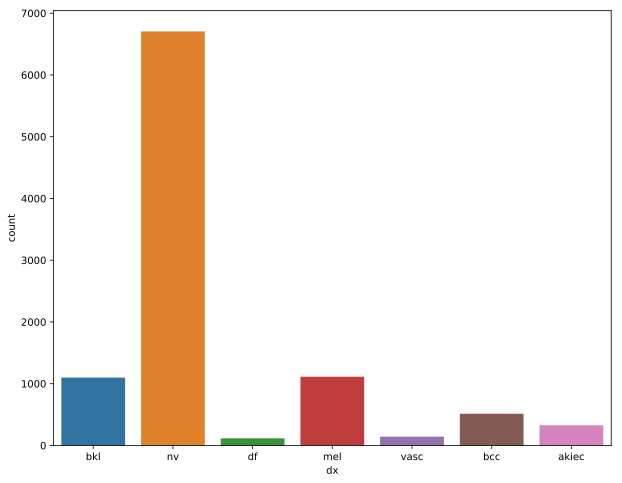

In [56]:
# make wrapping for cell_type names 
plt.figure(figsize=(10, 8))
sns.countplot(x='dx',data = skin_data)

Second plot

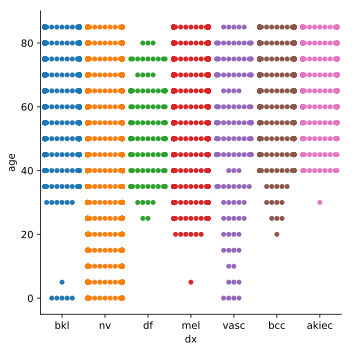

In [57]:
sns.catplot(x="dx", y="age", kind="swarm",
            data=skin_data);

Third Plot

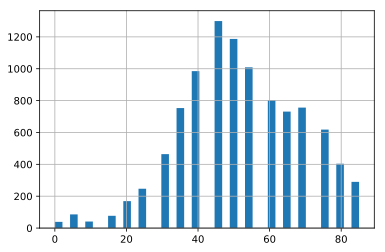

In [58]:
skin_data['age'].hist(bins=40)

Skin cancer images by cell type from baseline dataset

In [2]:
#  TODO show how skin lessions looks like 

### Loading images using opencv2 library, and choose with atm (Adaptive Mean Thresholding ) channel or without atm. 

In [5]:
frth_channel_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
IMAGE_DIMS = (100, 75, 3)
# default loading
def load_img(imagePath):
    image = cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    return image

# return image with higher increase brightness
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.resize(hsv, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img_to_array(img)
    return img

# return thresholding featrue transformation
def thresholding_feature(imagePath):
    img_grey = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    img_grey = cv2.resize(img_grey, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    # # Adaptive Gaussian
    img_grey = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img_grey, (3, 3), 0)
    ret3, img_binary = cv2.threshold(blur, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # invert black = 255
    # ret, thresh1 = cv2.threshold(img_binary, 157, 255, cv2.THRESH_BINARY_INV)
    img_binary = img_to_array(img_binary)
    return img_binary 

def load_atm_img(imagePath):
    img = cv2.imread(imagePath,0)
    img = cv2.resize(img, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    atm_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
    # TODO make it gray     
    atm_img = img_to_array(atm_img)
    return atm_img

def load_img_with_cv2(imagePath, frth_channel = 'without'):
    channel = False
    image = load_img(imagePath)
    sub_channel = 'no_channel'
    if frth_channel == 'atm':
        sub_channel = load_atm_img(imagePath)
        channel = True
    elif frth_channel == 'gray': 
        sub_channel = increase_brightness(image, 150)
        channel = True
    elif frth_channel == 'threshold':
        sub_channel = thresholding_feature(imagePath)
        channel = True
    image = img_to_array(image)
    if channel == True:
        multiImage = np.concatenate((image, sub_channel), axis=2) 
        return multiImage
    else: 
        return image
    
def load_gray(imagePath):
    image = load_img(imagePath)
    return increase_brightness(image, 150)

# Some tests 

In [6]:
frth_channel = 'gray'
test_skin_path = skin_data['path'][25]
test_image = load_img_with_cv2(test_skin_path, frth_channel)
test_image.shape

(100, 75, 4)

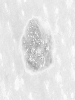

In [7]:
test_image = load_gray(test_skin_path)
img = array_to_img(test_image)
img

### load baseline image data 

In [8]:
data = []
for img_path in cut_skin_data['path']:
#     data.append(load_img_with_cv2(img_path,frth_channel ))
    data.append(load_img_with_cv2(img_path))
labels = np.array(cut_skin_data['dx'])

### load generate image data

In [9]:
generate_data = []
generate_labels = []
# for loop from dx from skin cancer recognition
for dx in cut_skin_data['dx'].unique():
    path_dir = 'generate_img/'+ dx + '/*.jpeg'  
    for filename in glob(path_dir):
#         img = load_img_with_cv2(filename, frth_channel)
        img = load_img_with_cv2(filename)
        generate_data.append(img)
        generate_labels.append(dx)

# Image preprocessing before Предобработка данных перед отправкой в CNN 

### splitting into test and training samples

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

### normalization baseline data

In [13]:
# x_train_mean = np.mean(X_train)
# x_train_std = np.std(X_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

# X_train = (X_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

### connect baseline dataset and generating dataset

In [33]:
generate_labels = np.array(generate_labels)
full_labels = np.concatenate((y_train, generate_labels))

generate_data = np.array(generate_data, dtype=np.uint8)
full_data = np.concatenate((x_train, generate_data))

### data normalization

In [13]:
full_data_mean = np.mean(full_data)

In [14]:
full_data_std = np.std(full_data)

In [15]:
full_data = (full_data - full_data_mean)/full_data_std

### One-hot encoding

In [ ]:
# custom one hot encoding 
# in labelbinazer order same as np.unique

In [30]:
np.unique(full_labels)

array(['bcc', 'bkl', 'mel', 'nv'], dtype=object)

In [34]:
full_labels

array(['nv', 'nv', 'mel', ..., 'bcc', 'bcc', 'bcc'], dtype=object)

In [ ]:
# scikit learn one hot encoding

In [35]:
mlb = LabelBinarizer()
full_labels = mlb.fit_transform(full_labels)
y_test = mlb.fit_transform(y_test)

In [36]:
full_labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

### splitting into test and validation samples

In [17]:
x_train, x_validate, y_train, y_validate = train_test_split(
    full_data, full_labels, 
    test_size = 0.1, random_state = 2)

### Check dimension size 

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

(17000, 100, 75, 1)
(17000, 4)
(1889, 100, 75, 1)
(1889, 4)
(1221, 100, 75, 1)
(1221, 4)


# Define metrics and optimizer for our model

In [19]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [20]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [21]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [22]:
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Neural Network Topology 

In [32]:
#  input shape using shape off test samples
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(100,75,1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
# model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
# model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
# model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(4))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 73, 32)        320       
_________________________________________________________________
activation_22 (Activation)   (None, 98, 73, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 49, 36, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 34, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 47, 34, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 17, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 15, 64)        36928     
__________

# Обучим нейронную сеть 



In [29]:
# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
# validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
# sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

In [33]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64 , validation_data=(x_validate, y_validate))

Train on 17000 samples, validate on 1889 samples
Epoch 1/20
17000/17000 [==============================] - 11s 632us/step - loss: 0.4659 - acc: 0.7687 - val_loss: 0.4239 - val_acc: 0.7947
Epoch 2/20
17000/17000 [==============================] - 10s 591us/step - loss: 0.4237 - acc: 0.7902 - val_loss: 0.4039 - val_acc: 0.8033
Epoch 3/20
17000/17000 [==============================] - 10s 568us/step - loss: 0.4068 - acc: 0.8005 - val_loss: 0.3801 - val_acc: 0.8203
Epoch 4/20
17000/17000 [==============================] - 10s 572us/step - loss: 0.3866 - acc: 0.8148 - val_loss: 0.3766 - val_acc: 0.8213
Epoch 5/20
17000/17000 [==============================] - 10s 567us/step - loss: 0.3687 - acc: 0.8265 - val_loss: 0.3612 - val_acc: 0.8302
Epoch 6/20
17000/17000 [==============================] - 10s 573us/step - loss: 0.3560 - acc: 0.8336 - val_loss: 0.3660 - val_acc: 0.8326
Epoch 7/20
17000/17000 [==============================] - 10s 568us/step - loss: 0.3414 - acc: 0.8427 - val_loss: 0.3

# Build graphics of CNN education 


In [34]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f  "  % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f ;" % (accuracy, loss))
# model.save_weights("weights.h5")
# print("Saved model to disk")

1889/1889 [==============================] - 0s 229us/step
Validation: accuracy = 0.838804  ;  loss = 0.445568  
Test: accuracy = 0.817772  ;  loss = 0.531489 ;


# Create a loss and accuracy plot 

In [35]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [36]:
def show_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

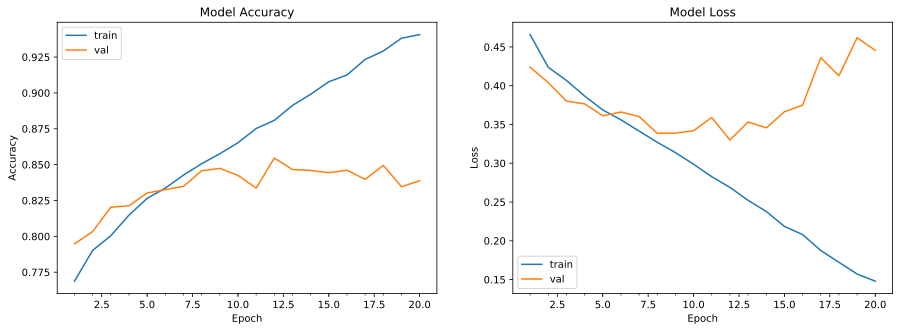

In [37]:
plot_model_history(history)

# Create a confusion matrix


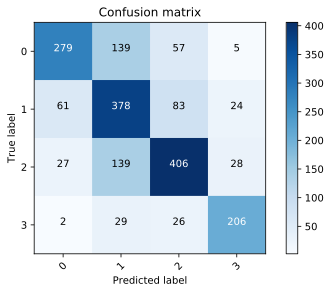

In [38]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

In [38]:
cut_skin_data['dx'].unique()

array(['bkl', 'nv', 'mel', 'bcc'], dtype=object)

which category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

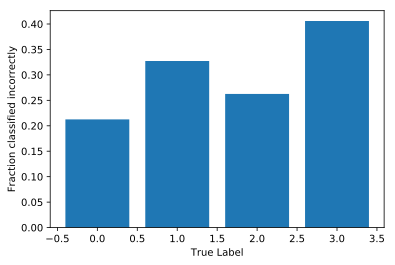

In [35]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

# Выгрузим промежуточные изображения из слоёв нейронной сети 

Функция для отрисовки изображений

In [40]:
def print_map_features(activation):
    images_per_row = 8
    n_filters = activation.shape[-1]
    size = activation.shape[1]
    size2 = activation.shape[2]
    n_cols = n_filters // images_per_row
    display_grid = np.zeros((n_cols * size, images_per_row * size2))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size2 : (row + 1) * size2] = channel_image
        
    scale = 2.5 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [43]:
img_for_feature_draw = x_test[120]

# Первый слой 

In [48]:
first_activation_model = models.Model(inputs=model.input, outputs=model.layers[0].output)
first_layers_activation = first_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
first_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


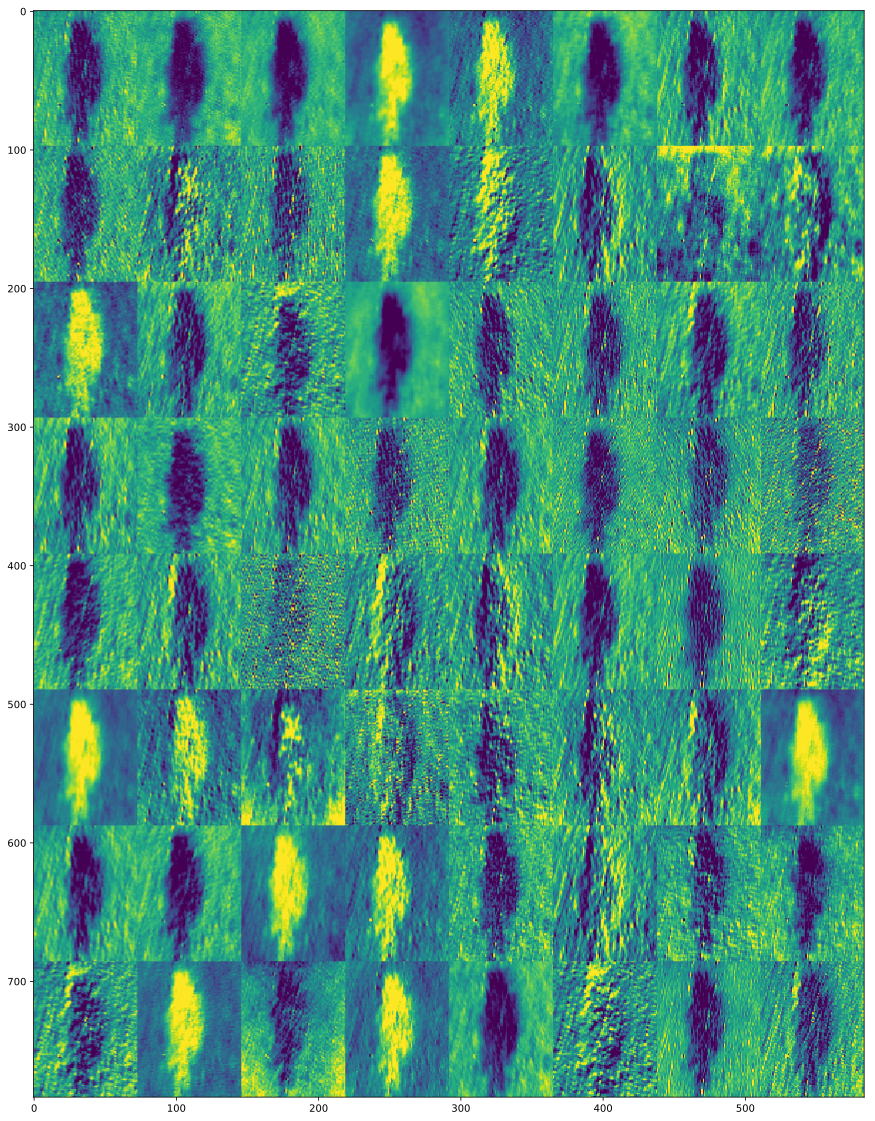

In [49]:
print_map_features(first_layers_activation)

# Второй слой 

In [50]:
second_activation_model = models.Model(inputs=model.input, outputs=model.layers[3].output)
second_layers_activation = second_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
second_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


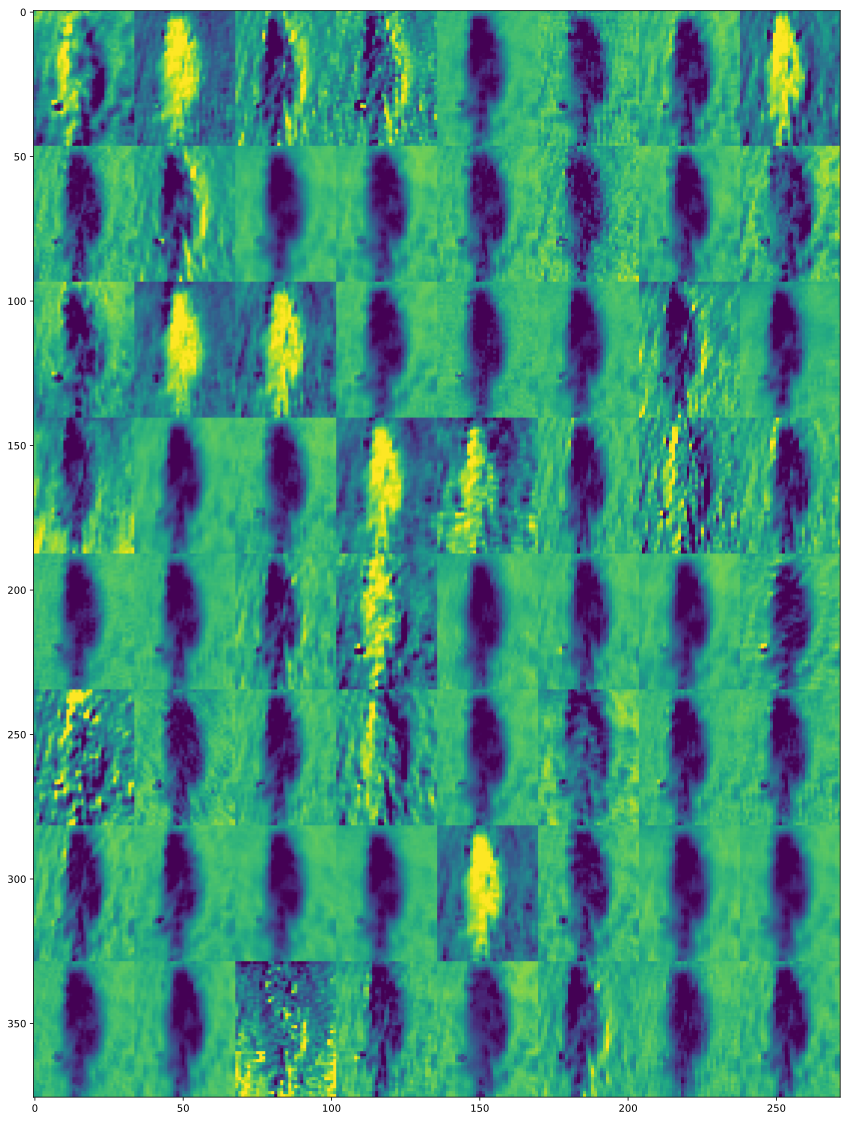

In [51]:
print_map_features(second_layers_activation)

# Третий слой

In [52]:
third_activation_model = models.Model(inputs=model.input, outputs=model.layers[6].output)
third_layers_activation = third_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
third_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 47, 34, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 17, 64)        0         
__________

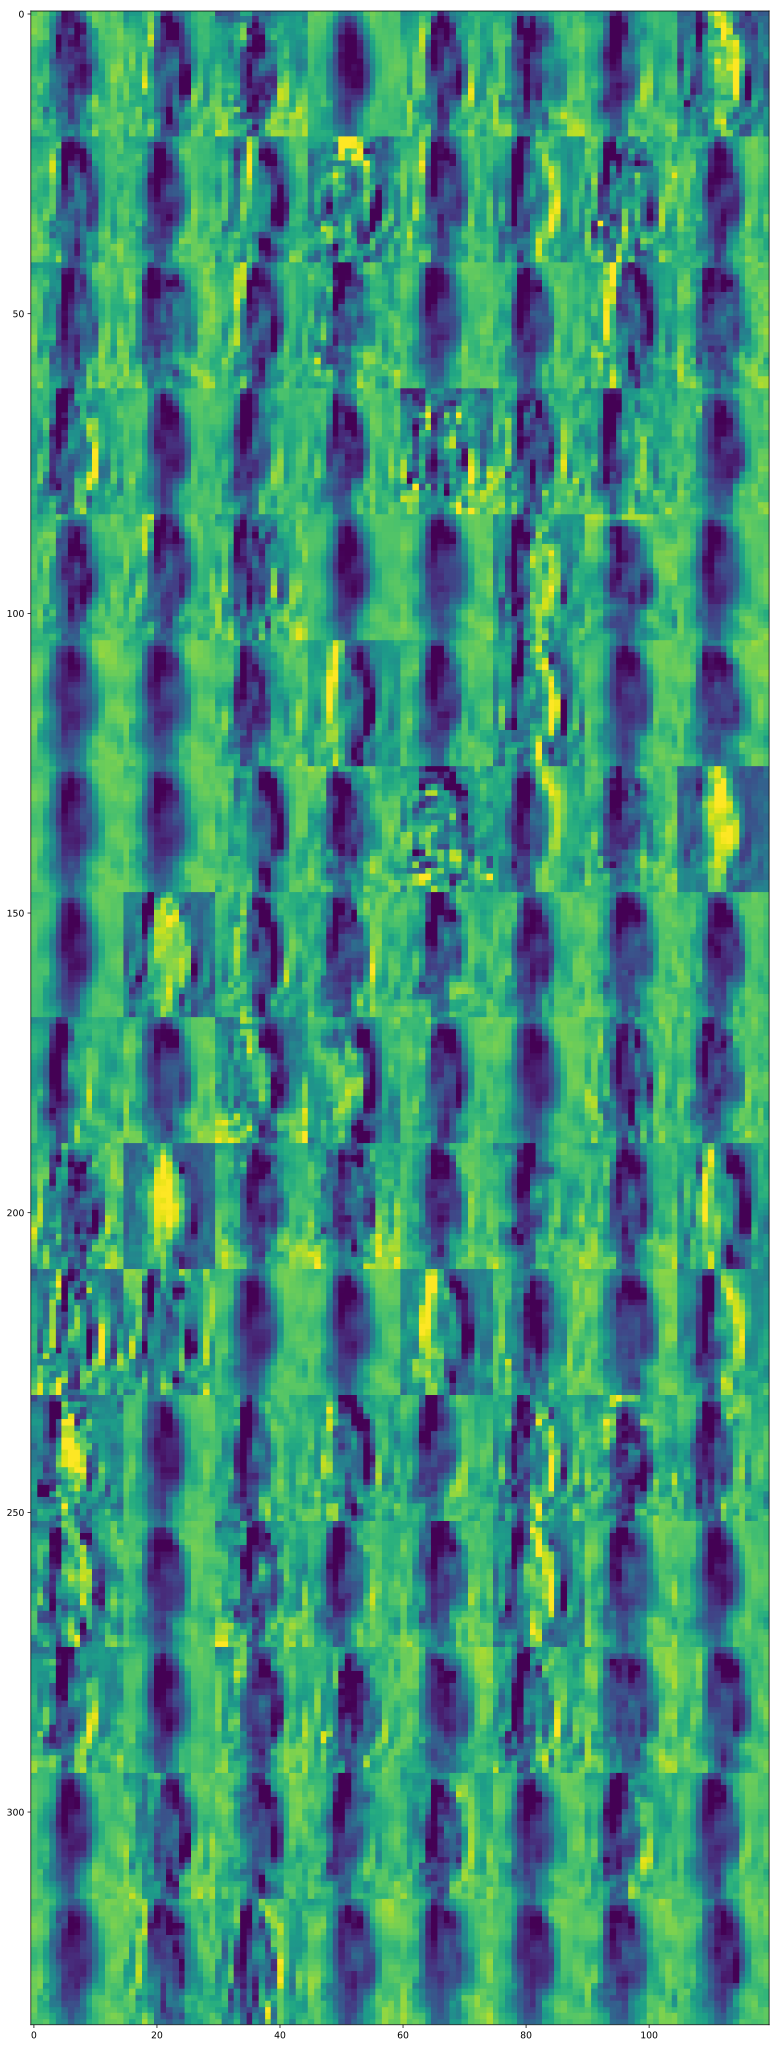

In [53]:
print_map_features(third_layers_activation)

# Четвертый слой 

In [54]:
Frth_activation_model = models.Model(inputs=model.input, outputs=model.layers[9].output)
Frth_layers_activation = Frth_activation_model.predict(np.expand_dims(img_for_feature_draw, axis=0))
Frth_activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  (None, 100, 75, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 98, 73, 64)        1792      
_________________________________________________________________
activation_8 (Activation)    (None, 98, 73, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 34, 64)        36928     
_________________________________________________________________
activation_9 (Activation)    (None, 47, 34, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 17, 64)        0         
__________

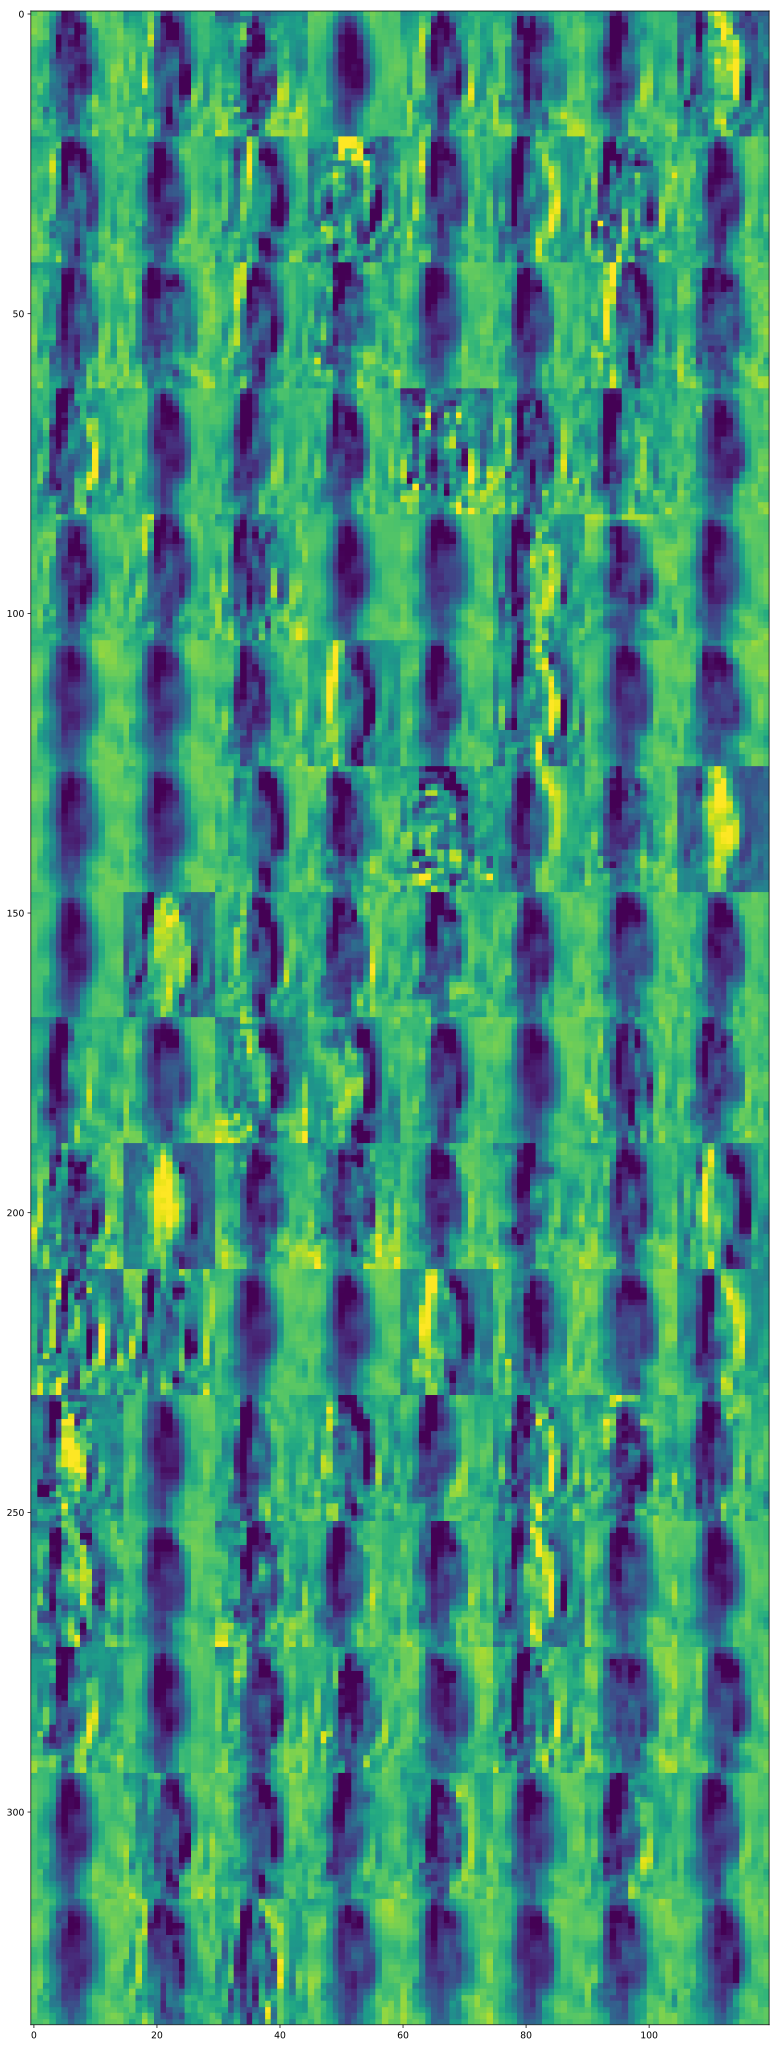

In [55]:
print_map_features(third_layers_activation)

# визуализируем веса слоёв нейронной сети 